In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_experimental as pmx

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
data = np.loadtxt("marketing.csv", skiprows=1, delimiter=",")
X = data[:, 0, None]
Y = data[:, 1]

In [4]:
with pm.Model() as model:
    α = pm.HalfNormal("α", 50)
    β = pm.HalfNormal("β", 5)
    μ = pm.Deterministic("μ", np.sqrt(α + β * X[:, 0]))
    σ_ = pmx.BART("σ_", X, Y, m=50)
    σ = pm.Deterministic("σ", np.abs(σ_))
    y = pm.Normal("y", μ, σ, observed=Y)
    idata = pm.sample(target_accept=0.99, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α, β]
>PGBART: [σ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


/home/osvaldo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


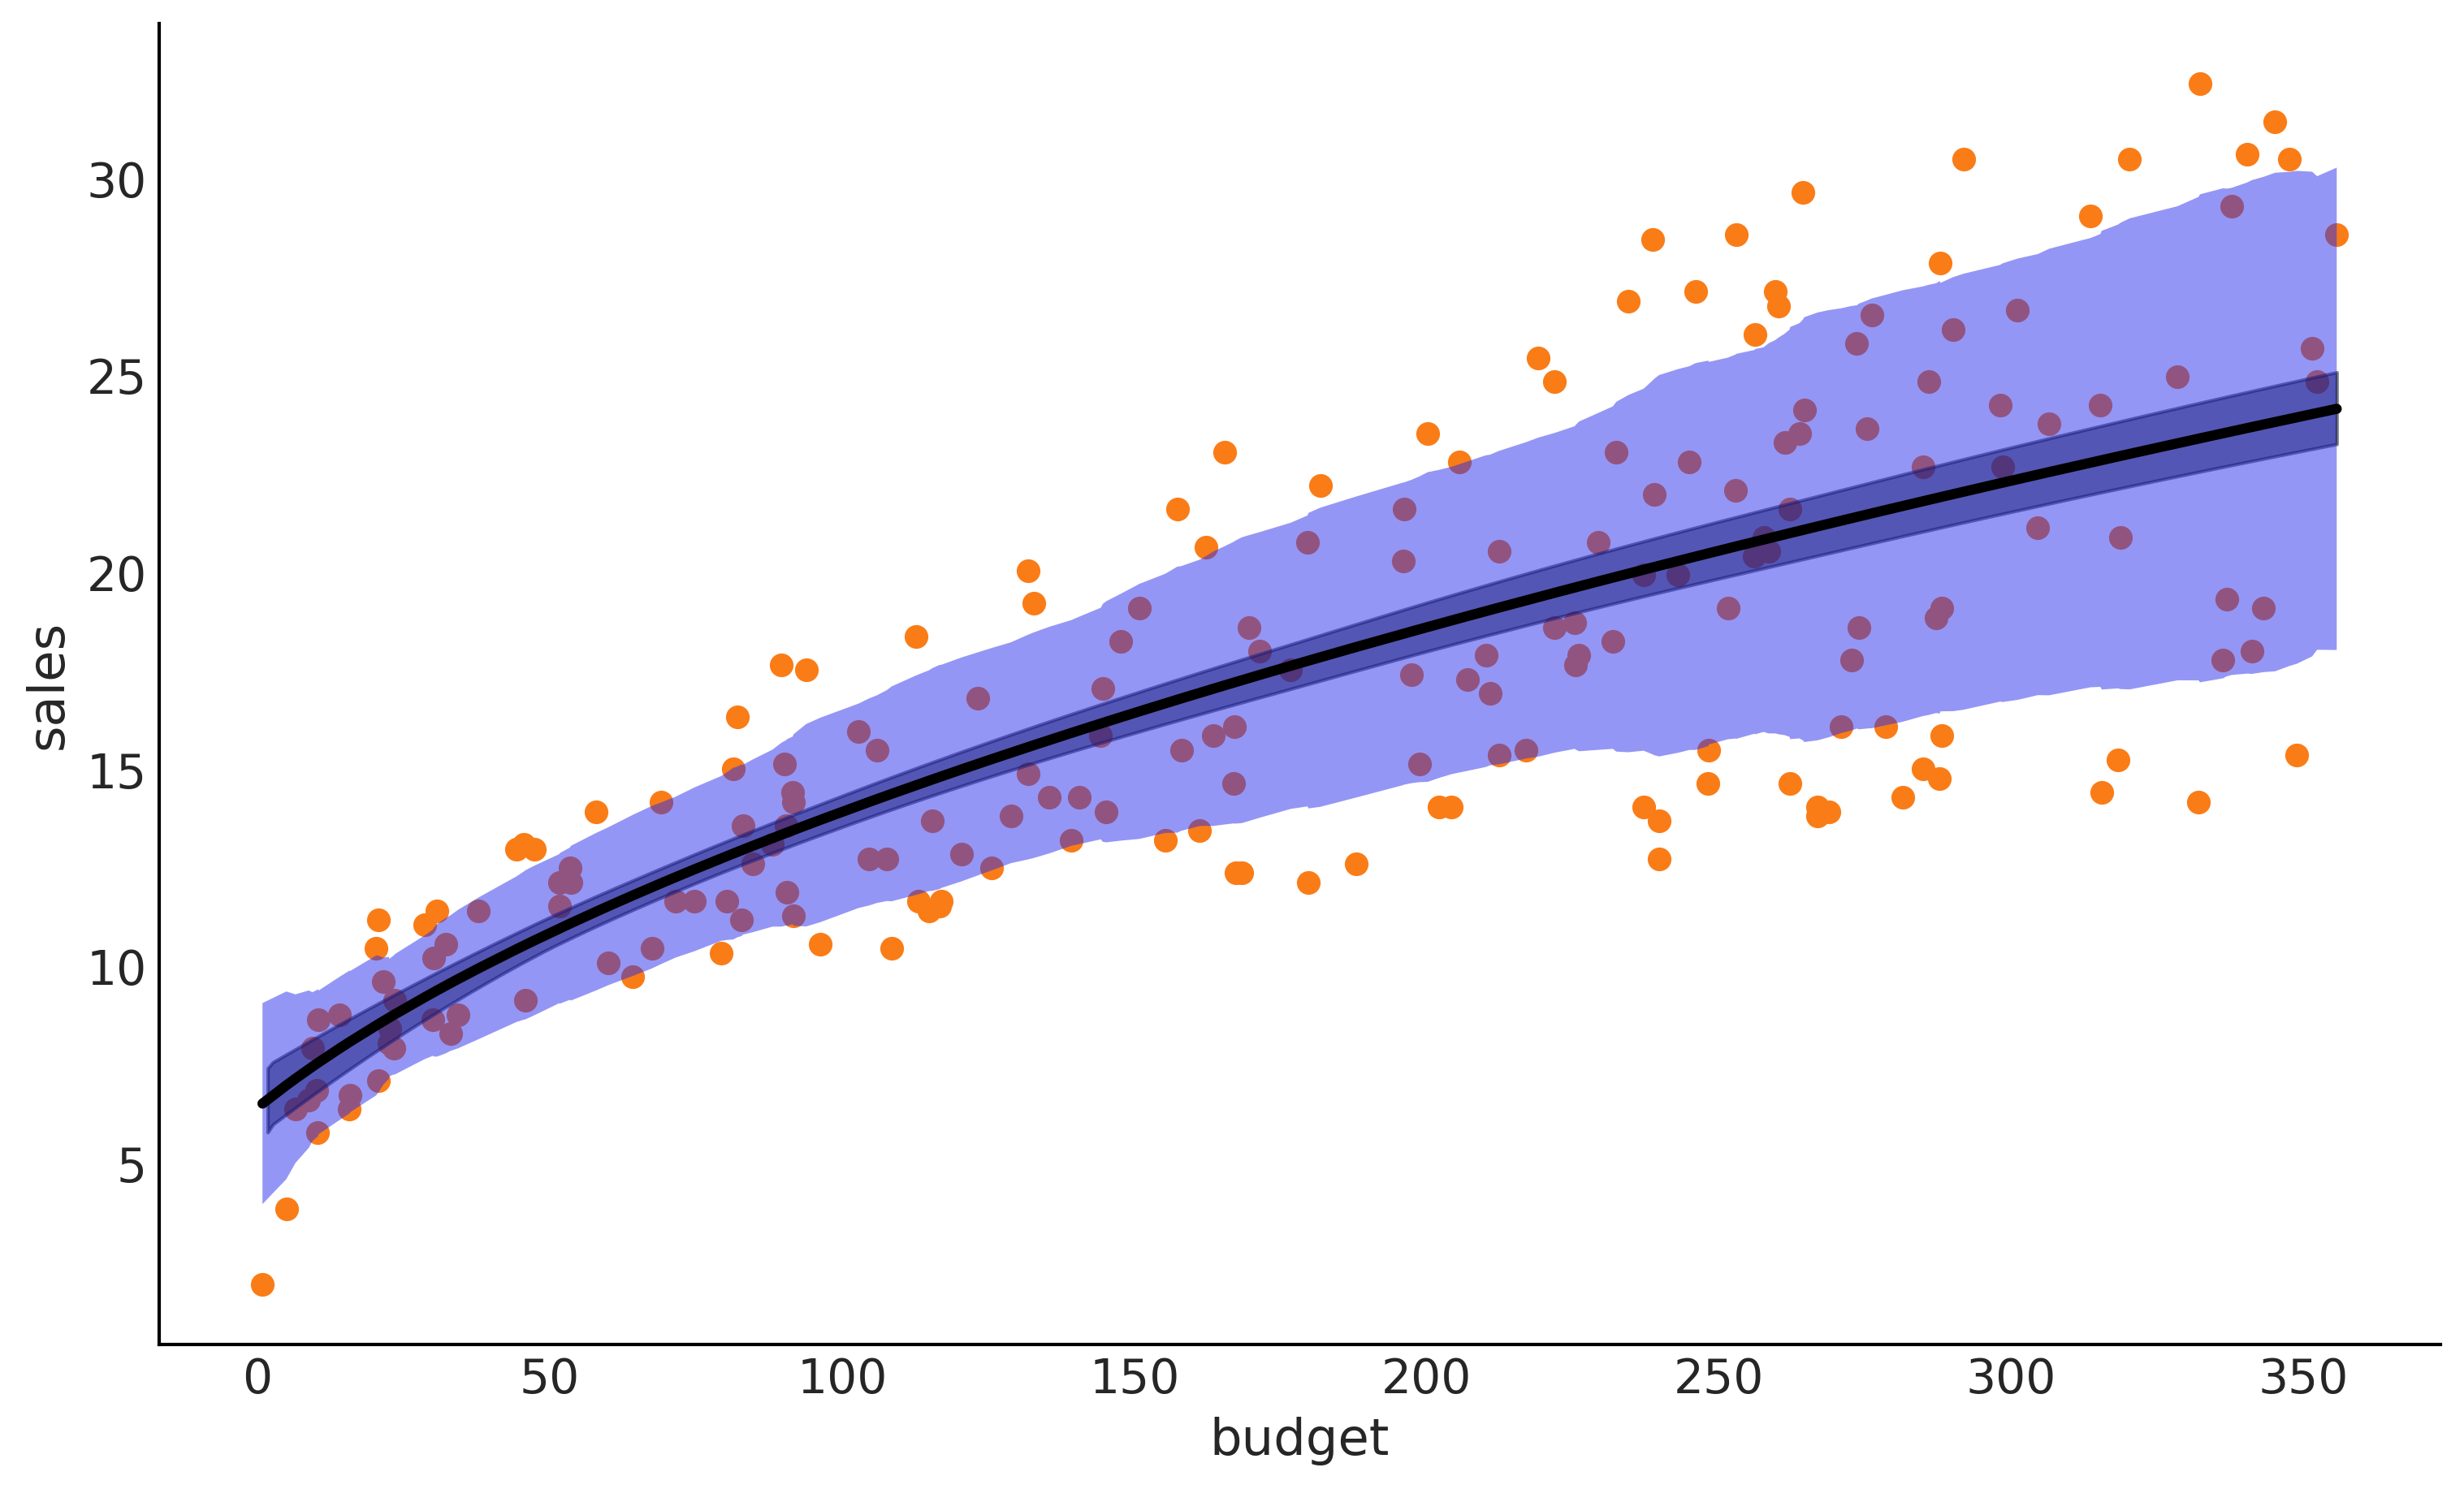

In [5]:
_, ax = plt.subplots(figsize=(10, 6))

mean = idata.posterior["μ"].mean(dim=["draw", "chain"]).values
mean_s = idata.posterior["μ"].stack(samples=["draw", "chain"]).values
idx = np.argsort(X[:, 0])
ax.plot(X[:, 0][idx], mean[idx], "k", lw=3)
az.plot_hdi(X[:, 0], mean_s.T, color="k")
sigma = idata.posterior["σ"].mean(dim=["draw", "chain"]).values
ax.fill_between(X[:, 0][idx], mean[idx] - sigma[idx], mean[idx] + sigma[idx], alpha=0.5)

ax.plot(X[:, 0], Y, "C1o", zorder=0)
ax.set_xlabel("budget")
ax.set_ylabel("sales")
plt.savefig("marketing.png")